<a href="https://colab.research.google.com/github/caesarcc/python-tcc-url-fakenews-check/blob/main/jupyter/classificacao_passo01_pre_processamento_exploracao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Abrir no Colab"/></a>

## Pré-processamento e explocação do Modelo de Classificação

In [86]:
# Imports
import os
import re
import spacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display
%matplotlib inline

### Baixar os dados do [Fake.br-Corpus](https://github.com/roneysco/Fake.br-Corpus)

*Atenção:* Para rodar localmente, é preciso salvar o pacote Fake.br-Corpus no diretorio do projeto.

In [ ]:
!git clone https://github.com/roneysco/Fake.br-Corpus

### Carregando os dados

Vou utilizar a amostra "size_normalized_texts" do Corpus dado que ela ajuda a evitar viéses no treino, conforme informação disponível na documentação. Cada par de texto verdadeiro ou falso possui a mesma quantidade de palavras, truncando o maior pelo menor.

In [67]:
DADOS_CAMINHO = "./Fake.br-Corpus/size_normalized_texts"

def load_txts(path):
    txts = []
    for filename in sorted(os.listdir(path), key=lambda x: int(re.match("[0-9]+", x).group())):
        with open(os.path.join(path, filename)) as f:
            txts.append(f.read())
    return [txt.rstrip() for txt in txts]

true_txts = load_txts(os.path.join(DADOS_CAMINHO, "true"))
fake_txts = load_txts(os.path.join(DADOS_CAMINHO, "fake"))

#confere se tem a mesma quantidade (dataset é balanceado)
assert(len(true_txts) == len(fake_txts))

dados = pd.DataFrame(
    [{"texto": t, "classe": 0} for t in true_txts] \
         + [{"texto": f, "classe": 1}  for f in fake_txts]
)
pd.set_option("display.max_rows", 50, 'display.max_colwidth', 200)
display(dados[dados['texto'].str.len()<100].sample(n=3)[['classe', 'texto']])

,classe,texto
4892,1,Coreia do Norte lança mais um míssil balístico e avisa que haverá outros durante o fim de semana. .
1093,0,A melhor viagem que alguém pode fazer. A viagem dos sonhos pode ser de muitas
3225,0,Estudo confirma que o vírus da zika não é transmitido pela saliva . Baixas


### Exploração e limpeza de dados

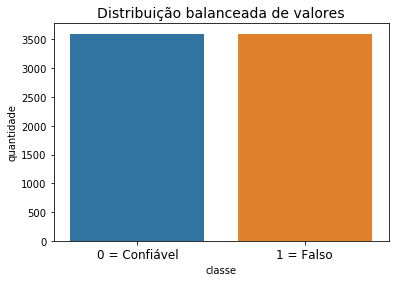

In [68]:
ax = sns.countplot(x="classe", data=dados)
ax.set_xticklabels(["0 = Confiável", "1 = Falso"], fontsize=12)
ax.set_title('Distribuição balanceada de valores', fontsize=14)
ax.set_ylabel('quantidade')
plt.show()

In [69]:
def conta_palavras(texto):
    qtdes = []
    for linha in texto:
        qtdes.append(len(re.findall(r"[\w']+|[.,!?;:/\"]", linha)))
    return np.array(qtdes)

def distribiucao_palavras(dados, campo, titulo):
    contagem = conta_palavras(dados[campo].values)
    intervalo = list(range(0, 601, 50))

    plt.figure(figsize=(8,6))
    plt.rcParams.update({'font.size': 14})
    plt.hist(contagem, rwidth=0.9, edgecolor='black', linewidth=1, bins=intervalo)
    plt.xticks(intervalo)
    plt.title(titulo)
    plt.xlabel("Qtde palavras ou pontuação", fontsize=14, fontweight="bold")
    plt.ylabel("Qtde de amostras", fontsize=14, fontweight="bold")

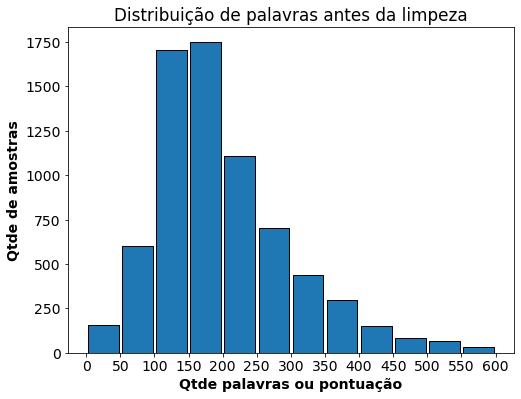

In [70]:
distribiucao_palavras(dados, "texto", "Distribuição de palavras antes da limpeza")

In [80]:
# Limpar textos
def limpar_textos(texto):
    texto = str(texto).replace(r'http[\w:/\.]+', ' ')  # remover urls
    texto = str(texto).replace(r'[^\.\w\s]', ' ')  # remover tudo exceto caracters e pontuação
    # Correção das pontuações duplicadas, há muitos casos no dadaset
    texto = re.sub(r'(\W)(?=\1)', '', str(texto)).replace(". .", ".")
    texto = str(texto).replace('[^a-zA-Z]', ' ')
    texto = str(texto).replace(r'\s\s+', ' ')
    texto = texto.lower().strip()
    return texto

dados["texto_limpo"] = dados.texto.apply(limpar_textos)
dados.sample(n=5)

,texto,classe,texto_limpo
232,"Para reduzir gastos, gestão Temer quer rever distribuição de remédio Um dos mais conhecidos programas do Ministério da Saúde, o Farmácia Popular, iniciativa que oferta medicamentos gratuitos ou co...",0,"para reduzir gastos, gestão temer quer rever distribuição de remédio um dos mais conhecidos programas do ministério da saúde, o farmácia popular, iniciativa que oferta medicamentos gratuitos ou co..."
3330,Escola de elfos preserva tradição dos seres lendários na Islândia. Pesquisador usa relatos para apontar que criaturas não são mitos. Pesquisas de opinião indicam que um em cada dois islandeses acr...,0,escola de elfos preserva tradição dos seres lendários na islândia. pesquisador usa relatos para apontar que criaturas não são mitos. pesquisas de opinião indicam que um em cada dois islandeses acr...
5747,"Angelina Jolie pediu o divórcio de Brad Pitt devido ao uso abusivo de álcool e ""ervas"" por parte do ator. O site TMZ publicou hoje (20) Angelina Jolie teria pedido o divórcio do ator Brad Pitt. ...",1,"angelina jolie pediu o divórcio de brad pitt devido ao uso abusivo de álcool e ""ervas"" por parte do ator. o site tmz publicou hoje (20) angelina jolie teria pedido o divórcio do ator brad pitt. de..."
7164,"A farra não para! Senado vai gastar R$ 50 mil para comprar xícaras com ""frisos dourados"". A informações são da ONG Contas Abertas. O senado empenhou R$ 47, 2 mil para a compra de diversos itens de...",1,"a farra não para! senado vai gastar r$ 50 mil para comprar xícaras com ""frisos dourados"". a informações são da ong contas abertas. o senado empenhou r$ 47, 2 mil para a compra de diversos itens de..."
5963,"Moro participa de reunião com petistas em Brasília e mulher grita: ""Cuidado com a carteira!"". O Juíz Federal Sergio Moro esteve no Congresso Federal na manhã de hoje (04). Moro foi participar de...",1,"moro participa de reunião com petistas em brasília e mulher grita: ""cuidado com a carteira!"". o juíz federal sergio moro esteve no congresso federal na manhã de hoje (04). moro foi participar de u..."


In [88]:
# Configuração da lib Spacy
!python -m spacy download pt_core_news_sm
nlp = spacy.load("pt_core_news_sm")

     ---------------------------------------- 22.2/22.2 MB 5.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [89]:
# Processamento com Spacy para Lematização
# Lemmatizer (o resultado é a raiz da palavra que existe na gramática, mantendo o contexto)
# Stemming (palavra resultante pode não existir, apenas reduz a dimencionalidade) 

# Remover stopwords    
dados["texto_sem_stop"] = dados.texto_limpo.apply(lambda texto: 
                                          " ".join(token.text for token in nlp(texto) 
                                                   if not token.is_stop))

# Lematizar
dados["texto_lematizado"] = dados.texto_sem_stop.apply(lambda texto: 
                                          " ".join(token.lemma_ for token in nlp(texto)))

In [1]:
# Confere resultados visualmente
dados.sample(n=5)

NameError: name 'data' is not defined

In [ ]:
distribiucao_palavras(dados, "texto", "Distribuição de palavras original")
distribiucao_palavras(dados, "texto_limpo", "Distribuição com limpeza manual")
distribiucao_palavras(dados, "texto_lematizado", "Distribuição sem stopwords e lematizada")

In [ ]:
# initialize the word cloud
wordcloud = WordCloud( background_color='black', width=800, height=600)
# generate the word cloud by passing the corpus
text_cloud = wordcloud.generate(' '.join(dados['text']))
# plotting the word cloud
plt.figure(figsize=(20,30))
plt.imshow(text_cloud)
plt.axis('off')
plt.show()

In [ ]:
# Salva dados para uso no notebook do próximo passo.
dados.to_csv('dados/fakebr_corpus_processado.csv', sep = ',', index = True)